# sklearn practice
to get an understanding of sklearn, build a neural network that predicts rssmax based on three other factors

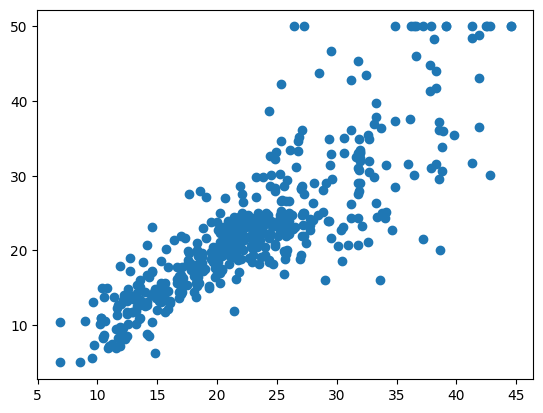

In [5]:
# epmt_query contains the EPMT Query API
import epmt_query as eq
# epmt_outliers contains the EPMT Outlier Detection API
import epmt_outliers as eod
# epmt_stat contains statistical functions
import epmt_stat as es
import pandas as pd
import numpy as np
#import sklearn modules. complicated due to needing to update version
   #nearest neighbors method
import sys
sys.path.insert(0,'/home/Ian.Laflotte/ians_py374/pip_experiment')
import matplotlib.pylab as plt

import importlib
skl_spec= importlib.util.spec_from_file_location('sklearn','/home/Ian.Laflotte/ians_py374/pip_experiment/sklearn/__init__.py')
sklearn = importlib.util.module_from_spec(skl_spec)
skl_spec.loader.exec_module(sklearn) 

# skl should now be callable
#help(skl)
sklearn.__version__

from sklearn.datasets import load_boston
from sklearn.neighbors import KNeighborsRegressor
X, y = load_boston(return_X_y = True)

model = KNeighborsRegressor().fit(X,y)
prediction = model.predict(X)
plt.style.use('default')
plt.scatter(prediction,y)

In [ ]:
#gaussian method
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
iris_X, iris_y = datasets.load_iris(return_X_y=True)
model = GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42).fit(x_train,y_train)
prediction = model.predict(x_test)

plt.style.use('default')
plt.scatter(prediction,y_test, s = 10)
plt.ylabel('true')
plt.xlabel('predicted')
plt.title('Gaussian')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.show()


# EPMT application
experimenting by working on EPMT predictions. want to predict rssmax for a job based on other metrics.

In [6]:
#get data for test. currently designed around rssmax always being whats predicted, but other variables change merely by adding to variables[]
from sklearn.model_selection import train_test_split

training_jobs = []
for aa in range(1):
    jobs_temp = eq.get_jobs(limit=1000, before = -7, offset = 1100*aa, 
                           fmt='dict')
    training_jobs.extend(jobs_temp)

data = []
rssmax = []
variables = ['cpu_time','num_procs','write_bytes','duration']
for job in training_jobs:
    if job.get('rssmax'):
        rssmax.append(job['rssmax'])
        data.append([])
        for var in range(len(variables)):
            data[len(data)-1].append(job[variables[var]])
x_train, x_test, y_train, y_test = train_test_split(
  data,rssmax , random_state=104,test_size=0.25, shuffle=True)

/home/fms/local/epmt/4.9.2-centos-7/epmt-install/epmt/epmt:19: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/fms/local/epmt/4.9.2-centos-7/epmt-install/epmt/epmt:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


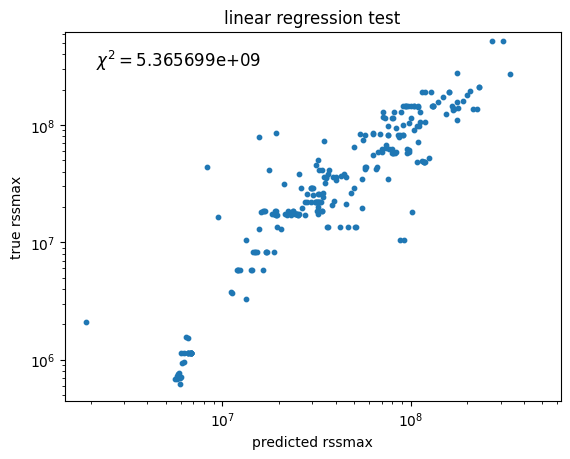

In [7]:
#make test model of linear regression
from sklearn.linear_model import LinearRegression 
model = LinearRegression().fit(x_train,y_train)
#apply test model
prediction = model.predict(x_test)
#chi squared
chi_squared = 0
for aa in range(len(prediction)):
    chi_squared += (prediction[aa]-y_test[aa])**2/y_test[aa]
plt.annotate(r'$\chi^2=$'+str("{:e}".format(chi_squared)),(.15,.83), color = 'black', fontsize =12,horizontalalignment='left',verticalalignment='center', xycoords='figure fraction')

plt.style.use('default')
plt.scatter(prediction,y_test, s = 10)
plt.ylabel('true rssmax')
plt.xlabel('predicted rssmax')
plt.title('linear regression test')
plt.yscale('log')
plt.xscale('log')
plt.xlim(.8*min(min(y_test),min(prediction)),1.2*max(max(y_test),max(prediction)))
plt.ylim(.8*min(min(y_test),min(prediction)),1.2*max(max(y_test),max(prediction)))
plt.show()

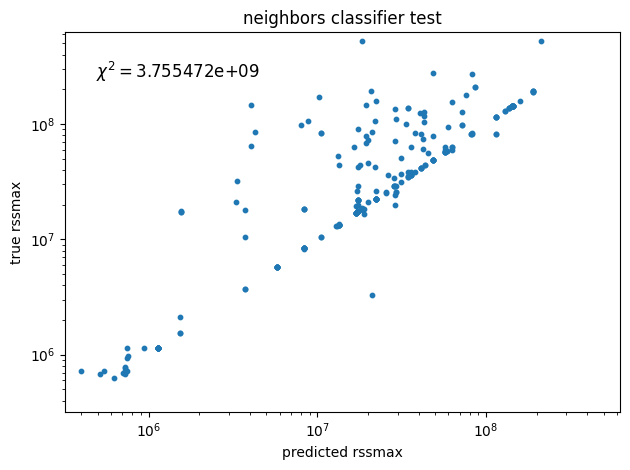

In [8]:
#Nearest neighbors method chosses average of nearest n points to quantify prediction. lower can be better.
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
classifier_knn = KNeighborsClassifier(n_neighbors = 5)   #simple tests show 5 works best
classifier_knn.fit(x_train,y_train)
prediction = classifier_knn.predict(x_test)
#chi squared
chi_squared = 0
for aa in range(len(prediction)):
    chi_squared += (prediction[aa]-y_test[aa])**2/y_test[aa]
#plotting
plt.style.use('default')
plt.scatter(prediction,y_test,s = 10)
plt.ylabel('true rssmax')
plt.xlabel('predicted rssmax')
plt.title('neighbors classifier test')
plt.yscale('log')
plt.xscale('log')
plt.xlim(.8*min(min(y_test),min(prediction)),1.2*max(max(y_test),max(prediction)))
plt.ylim(.8*min(min(y_test),min(prediction)),1.2*max(max(y_test),max(prediction)))
plt.annotate(r'$\chi^2=$'+str("{:e}".format(chi_squared)),(.15,.83), color = 'black', fontsize =12,horizontalalignment='left',verticalalignment='center', xycoords='figure fraction')
plt.tight_layout()
plt.show()

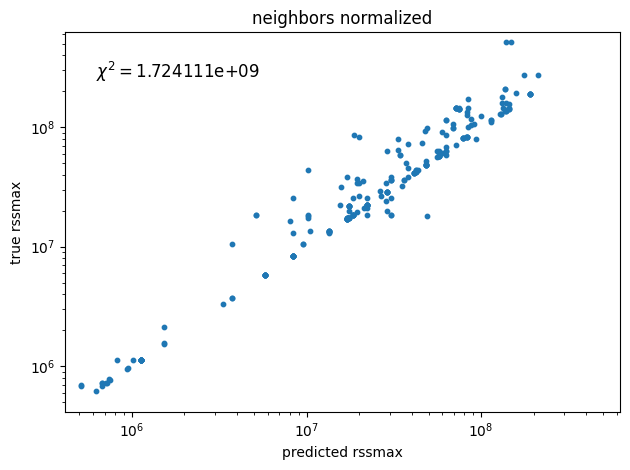

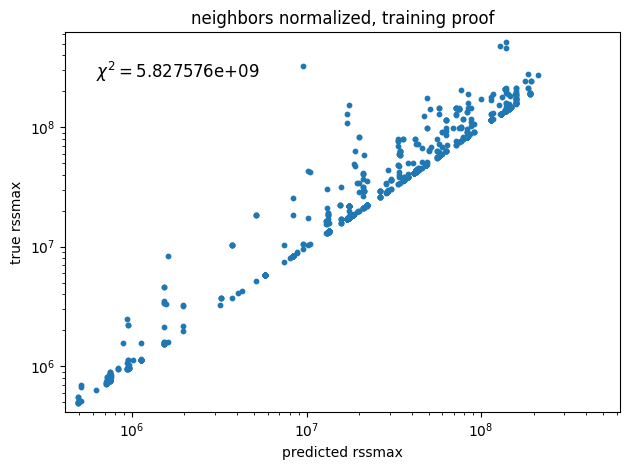

In [9]:
#redo Neighbors with quantile transform
#this will rescale the x_train and test data, allowing for different axis to match, and minimize impact of outliers
from sklearn.preprocessing import QuantileTransformer
trans = QuantileTransformer(n_quantiles=50, output_distribution='normal')
trans.fit(x_train)
x_train_transformed = trans.transform(x_train)
x_test_transformed = trans.transform(x_test)
classifier_knn = KNeighborsClassifier(n_neighbors = 5)
classifier_knn.fit(x_train_transformed,y_train)
prediction = classifier_knn.predict(x_test_transformed)
#chi squared
chi_squared = 0
for aa in range(len(prediction)):
    chi_squared += (prediction[aa]-y_test[aa])**2/y_test[aa]
plt.annotate(r'$\chi^2=$'+str("{:e}".format(chi_squared)),(.15,.83), color = 'black', fontsize =12,horizontalalignment='left',verticalalignment='center', xycoords='figure fraction')
plt.style.use('default')
plt.scatter(prediction,y_test, s = 10)
plt.ylabel('true rssmax')
plt.xlabel('predicted rssmax')
plt.title('neighbors normalized')
plt.yscale('log')
plt.xscale('log')
plt.xlim(.80*min(min(y_test),min(prediction)),1.20*max(max(y_test),max(prediction)))
plt.ylim(.80*min(min(y_test),min(prediction)),1.20*max(max(y_test),max(prediction)))
plt.tight_layout()
plt.show()

#proof of concept. Predict on data trained. should be very tight fit
proof_prediction = classifier_knn.predict(x_train_transformed)
plt.scatter(proof_prediction,y_train, s = 10)
plt.ylabel('true rssmax')
plt.xlabel('predicted rssmax')
plt.title('neighbors normalized, training proof')
plt.yscale('log')
plt.xscale('log')
plt.xlim(.80*min(min(y_test),min(prediction)),1.20*max(max(y_test),max(prediction)))
plt.ylim(.80*min(min(y_test),min(prediction)),1.20*max(max(y_test),max(prediction)))
chi_squared = 0
for aa in range(len(proof_prediction)):
    chi_squared += (proof_prediction[aa]-y_train[aa])**2/y_train[aa]
plt.annotate(r'$\chi^2=$'+str("{:e}".format(chi_squared)),(.15,.83), color = 'black', fontsize =12,horizontalalignment='left',verticalalignment='center', xycoords='figure fraction')
plt.tight_layout()
plt.show()

In [10]:
'''#MLPClassifier
from sklearn.neural_network import MLPClassifier
NN = MLPClassifier()
NN.fit(x_train, y_train)
prediction = NN.predict(x_test)
plt.style.use('default')
plt.scatter(prediction,y_test, s = 10)
plt.ylabel('true rssmax')
plt.xlabel('predicted rssmax')
plt.title('classifier NN')
plt.yscale('log')
plt.xscale('log')
plt.xlim(.80*min(min(y_test),min(prediction)),1.20*max(max(y_test),max(prediction)))
plt.ylim(.80*min(min(y_test),min(prediction)),1.20*max(max(y_test),max(prediction)))
plt.tight_layout()
plt.show()
'''

"#MLPClassifier\nfrom sklearn.neural_network import MLPClassifier\nNN = MLPClassifier()\nNN.fit(x_train, y_train)\nprediction = NN.predict(x_test)\nplt.style.use('default')\nplt.scatter(prediction,y_test, s = 10)\nplt.ylabel('true rssmax')\nplt.xlabel('predicted rssmax')\nplt.title('classifier NN')\nplt.yscale('log')\nplt.xscale('log')\nplt.xlim(.80*min(min(y_test),min(prediction)),1.20*max(max(y_test),max(prediction)))\nplt.ylim(.80*min(min(y_test),min(prediction)),1.20*max(max(y_test),max(prediction)))\nplt.tight_layout()\nplt.show()\n"

[[111669435.0, 6446, 311091200, 195554569.0],
 [452562136.0, 4444, 29293051904, 669743897.0],
 [106844109.0, 6556, 1206194176, 265103279.0],
 [70889552.0, 2993, 1037459456, 240534154.0],
 [861311071.0, 3086, 73393655808, 1196499605.0],
 [320828775.0, 14791, 72766562304, 1678258120.0],
 [283261917.0, 17577, 3307589632, 701588317.0],
 [59242596.0, 6446, 1134059520, 175712006.0],
 [71825874.0, 2405, 303669248, 123647987.0],
 [58274249.0, 4900, 2598854656, 508865484.0],
 [157819495.0, 1274, 33862103040, 229961497.0],
 [910107748.0, 3082, 73486761984, 1055729522.0],
 [622866289.0, 1157, 29958422528, 791660637.0],
 [862642239.0, 3082, 73461633024, 1015125242.0],
 [1948099.0, 116, 581632, 9475371.0],
 [263150601.0, 3348, 70256218112, 384618882.0],
 [63003718.0, 3435, 1082134528, 156079287.0],
 [60282881.0, 1174, 144773120, 109334373.0],
 [195125578.0, 5915, 5081686016, 1405878438.0],
 [129261727.0, 8761, 2698420224, 318963116.0],
 [401254206.0, 17542, 16888586240, 1241750043.0],
 [301838886.0